In [1]:
# 1) Wipe out all Python variables
%reset -f
# 2) Force Python’s garbage collector to run
import gc
gc.collect()

import importlib
from libs import trades, plots, params, models
importlib.reload(trades)
importlib.reload(plots)
importlib.reload(params)
importlib.reload(models)

import sys
print(sys.executable)

import math
import pandas as pd
from pandas import Timestamp
import numpy as np
import glob
import os
import datetime as dt
from datetime import datetime
from pprint import pprint
from collections import OrderedDict

import matplotlib.pyplot as plt
import plotly.graph_objects as go
from IPython.display import display, HTML
import seaborn as sns

from typing import Optional, Dict, Tuple, List, Sequence
from sklearn.preprocessing import StandardScaler

from tqdm.auto import tqdm
tqdm.pandas()        

pd.set_option('display.max_columns', None)



/usr/bin/python


[main] Found existing base CSV: dfs_training/AAPL_1_base.csv


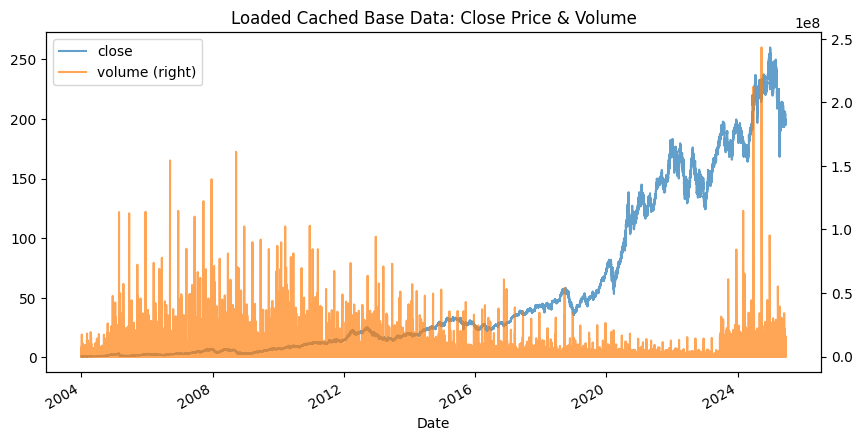

open        high         low       close  \
2004-01-02 11:30:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 11:31:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 11:32:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 11:33:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 11:34:00    0.764286    0.764286    0.764286    0.764286   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  196.680000  196.860000  196.630000  196.815000   
2025-06-18 20:57:00  196.810000  196.940000  196.560000  196.675000   
2025-06-18 20:58:00  196.675000  196.740000  196.630000  196.670000   
2025-06-18 20:59:00  196.680000  196.750000  196.240000  196.240000   
2025-06-18 21:00:00  196.580000  196.650000  196.080000  196.540000   

                         volume         ask         bid  
2004-01-02 11:30:00     28000.0    0.764514    0.764057  
2004-01-02 11:31:00     28000.0    0.764514    0.764057  
2004-01-02 11:32:00     28000.0    0.764514    0.764057  
2004-01-02 11:33:00     28000.0    0.764514    0.764057  
2004-01-02 11:34:00     28000.0    0.764514    0.764057  
...                         ...         ...         ...  
2025-06-18 20:56:00    385695.0  196.874000  196.756000  
2025-06-18 20:57:00    460630.0  196.734000  196.616000  
2025-06-18 20:58:00    525245.0  196.729000  196.611000  
2025-06-18 20:59:00   2075503.0  196.298900  196.181100  
2025-06-18 21:00:00  15600625.0  196.599000  196.481000  

[3083400 rows x 7 columns]

In [2]:
ticker = params.ticker
base_csv = params.base_csv

if os.path.exists(base_csv):
    # -----------------------------------------------------------------
    # 1) Cached file exists → load it, plot it, skip all processing.
    # -----------------------------------------------------------------
    print(f"[main] Found existing base CSV: {base_csv}")
    df = pd.read_csv(base_csv, index_col=0, parse_dates=True)
    plots.plot_close_volume(
        df,
        title="Loaded Cached Base Data: Close Price & Volume"
    )

else:
    # -----------------------------------------------------------------
    # 2) No cached file → do the full split‐adjust and then minute‐grid prep
    # -----------------------------------------------------------------
    print(f"[main] No base CSV found; running process_splits …")
    df_raw = trades.process_splits(
        folder                   = params.stocks_folder,
        ticker                   = ticker,
        bidasktoclose_spread     = params.bidasktoclose_spread
    )

    # Once‐only minute grid build and interpolation
    print(f"[main] Running prepare_interpolate_data …")
    df = trades.prepare_interpolate_data(
        df                    = df_raw,
        regular_start_shifted = params.regular_start_shifted,
        regular_start         = params.regular_start,
        regular_end           = params.regular_end
    )
    
    # Persist to base CSV and return
    df.to_csv(base_csv)
    print(f"[process_splits] Saved processed data to: {base_csv}")

# df is now guaranteed to be the split‐adjusted, minute‐aligned DataFrame
df


In [3]:
global_ref  = trades.compute_global_ref_profit(df = df)
global_ref # reference median used to scale the signal

0.00366300366300373

In [4]:
def process_single_day(day_str, buy_threshold): 
    # Processes one calendar day, called by the function 'saveDF_checkDAY'
    print(f"\n=== Processing trading day {day_str} ===")
    day_dt = pd.to_datetime(day_str)
    day_df = df.loc[df.index.normalize() == day_dt].copy()
    if day_df.empty:
        print(" no data; skipping.")
        return
            
    print("\n Running trading pipeline on selected date …")
    result = trades.run_trading_pipeline(day_df, 
                                         col_signal='signal',
                                         col_action='signal_action',
                                         ref_profit=global_ref,
                                         day_to_check=day_str)
    
    if result is None:
        print(" no trades found; skipping.")
        return

    df_day, trades_day, perf_day = result
    plots.plot_trades(
        df=df_day,
        col_signal1='signal',
        col_signal2=False,
        col_action='signal_action',
        trades=trades_day,
        buy_threshold=buy_threshold,
        performance_stats=perf_day
    )

    print(f"\n=== Performance for {day_dt} ===")
    for k, v in perf_day.items():
        print(f"{k}: {v}")

    return df_day, perf_day


In [5]:
def saveDF_checkDAY(
    df,
    ticker,
    min_prof_thr,
    max_down_prop,
    gain_tightening_factor,
    smooth_win_sig,
    pre_entry_decay,
    buy_threshold,
    trailing_stop_thresh,
    merging_retracement_thr,
    merging_time_gap_thr
):
    """
    Modes:
      • date_to_check Month ('YYYY-MM')   → process each day, then summary  
      • createCSVready  → full‐run: smooth ALL, pipeline, merge+interpolate w/ progress, save CSV  
    """
    
    keep_cols = [
        "open","high","low","close","volume", "bid","ask", "StrategyEarning","EarningDiff", "signal", "signal_action"
    ]

    print(f"\nMonth mode: processing {params.date_to_check}")

    # collect all days in this month
    dates_days = (
        df.loc[df.index.strftime("%Y-%m") == params.date_to_check]
          .index.normalize()
          .unique()
    )

    performance_list = []
    daily_frames     = []
    
    for date_day in sorted(dates_days.astype(str)):
        res = process_single_day(date_day, buy_threshold)
        if res is None:
            continue

        df_day, perf_day = res
        daily_frames.append(df_day)       # collect the day’s DF
        performance_list.append(perf_day) # collect its stats

    if not daily_frames:
        print("No valid days in this month.")
        return

    # build the month‐DF from exactly those df_day’s
    df_month = pd.concat(daily_frames).sort_index()
    # print monthly performance summary
    plots.aggregate_performance(performance_list, df_month)

    if params.createCSVready == False:

        return df_month

    else: # if createCSVready == True:
        
        print(f"\nFull-run mode")
        
        print("\n•Running trading pipeline on full dataset …")
        full_sim_results = trades.run_trading_pipeline( 
            df,
            col_signal='signal',
            col_action='signal_action',
            ref_profit=global_ref,
            day_to_check=None
        )
    
        print("\n•Merging, concatenating all days, and calculating test performances …")
        daily_frames    = [res[0][keep_cols] for res in full_sim_results.values()]
        df_all          = pd.concat(daily_frames).sort_index()
        performance_all = [res[2] for res in full_sim_results.values()]
        plots.aggregate_performance(performance_all, df_all)
        days_all = df_all.index.normalize().unique()
    
        # prepare the performances summary just for the test days
        cutoff   = int(len(days_all) * (params.train_prop + params.val_prop))
        test_days = days_all[cutoff:][1:]   # to use the same test days as in the model test prediction
        df_test = df_all[ df_all.index.normalize().isin(test_days) ]
        performance_test = [perf
                            for day, (_,_,perf) in full_sim_results.items()
                            if pd.Timestamp(day).normalize() in test_days]
        plots.aggregate_performance(performance_test, df_test)    
    
        print("\n•Saving CSV …")
        ready_csv = params.ready_csv
        df_all.to_csv(ready_csv)
        print(f"Saved to {ready_csv}")
    
        return df_all




Month mode: processing 2004-03

=== Processing trading day 2004-03-01 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


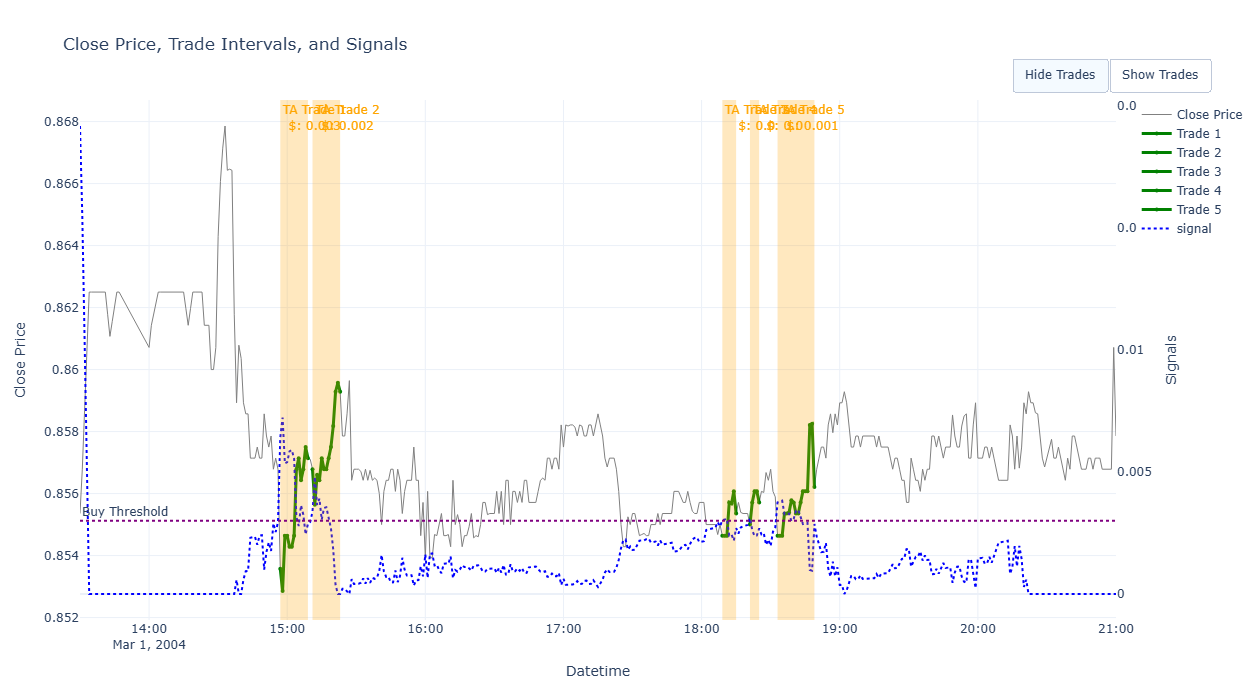


=== Performance for 2004-03-01 00:00:00 ===
Buy & Hold Return ($): -0.007
Strategy Return ($): 0.007
Trades Returns ($): [0.003, 0.002, 0.0, 0.0, 0.001]

=== Processing trading day 2004-03-02 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


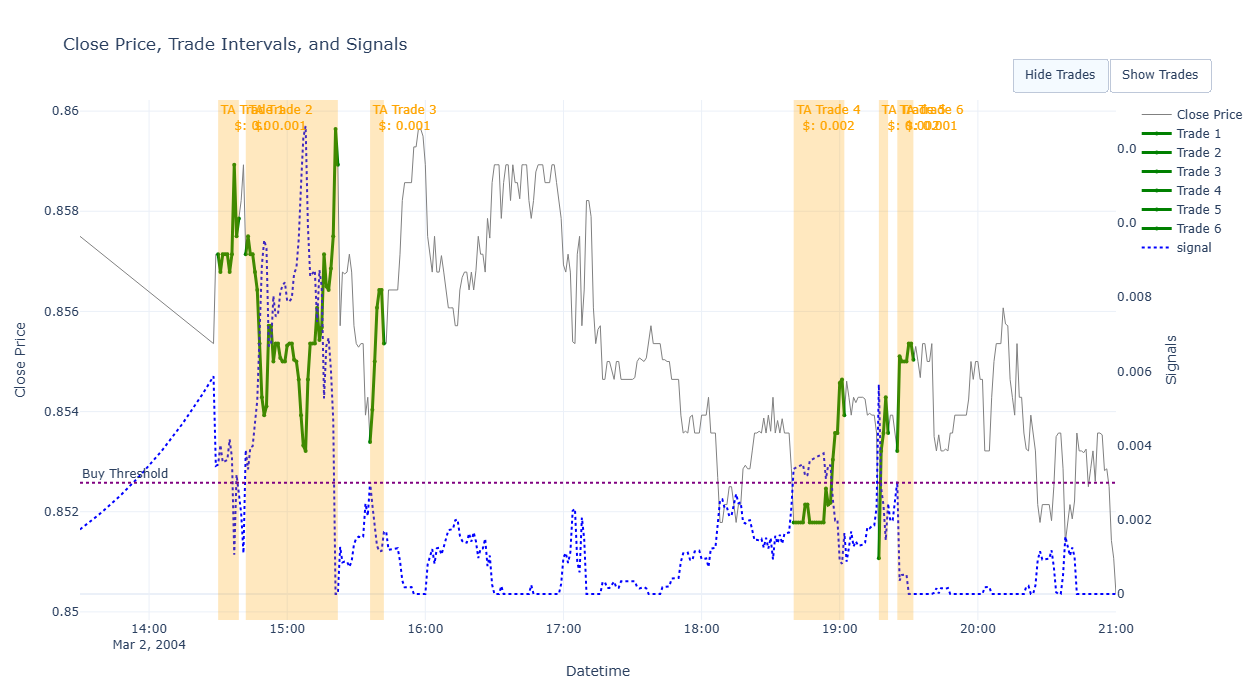


=== Performance for 2004-03-02 00:00:00 ===
Buy & Hold Return ($): -0.007
Strategy Return ($): 0.008
Trades Returns ($): [0.0, 0.001, 0.001, 0.002, 0.002, 0.001]

=== Processing trading day 2004-03-03 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


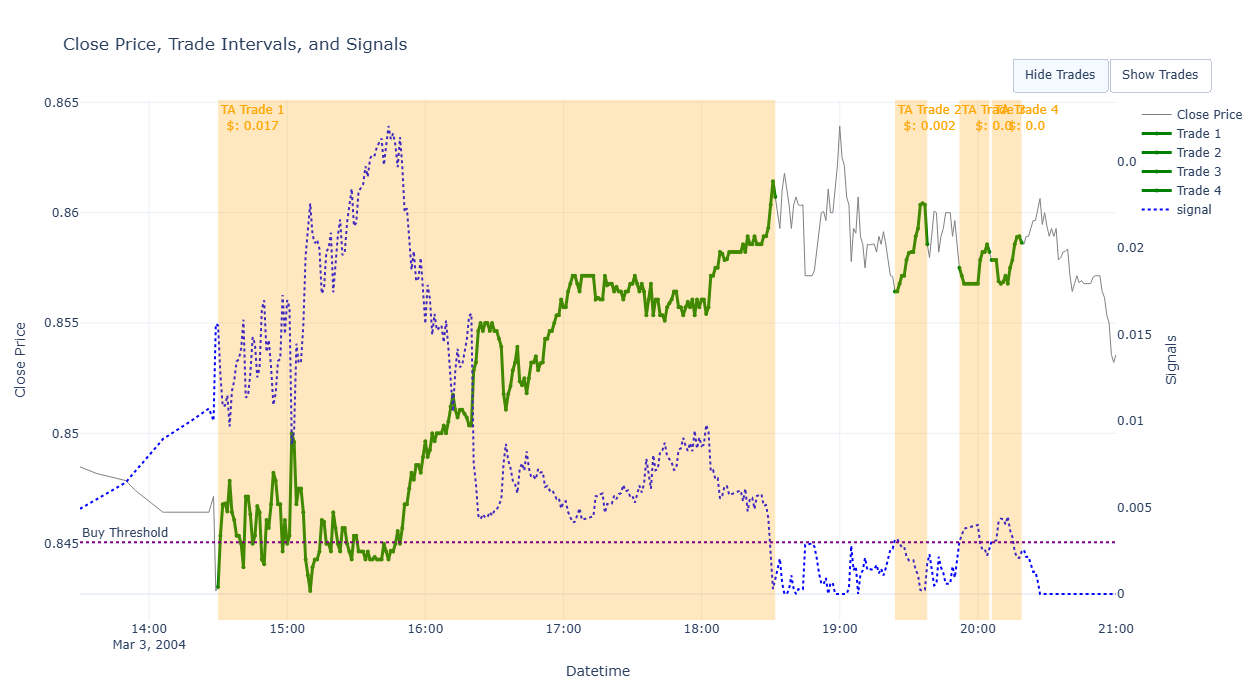


=== Performance for 2004-03-03 00:00:00 ===
Buy & Hold Return ($): 0.01
Strategy Return ($): 0.019
Trades Returns ($): [0.017, 0.002, 0.0, 0.0]

=== Processing trading day 2004-03-04 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


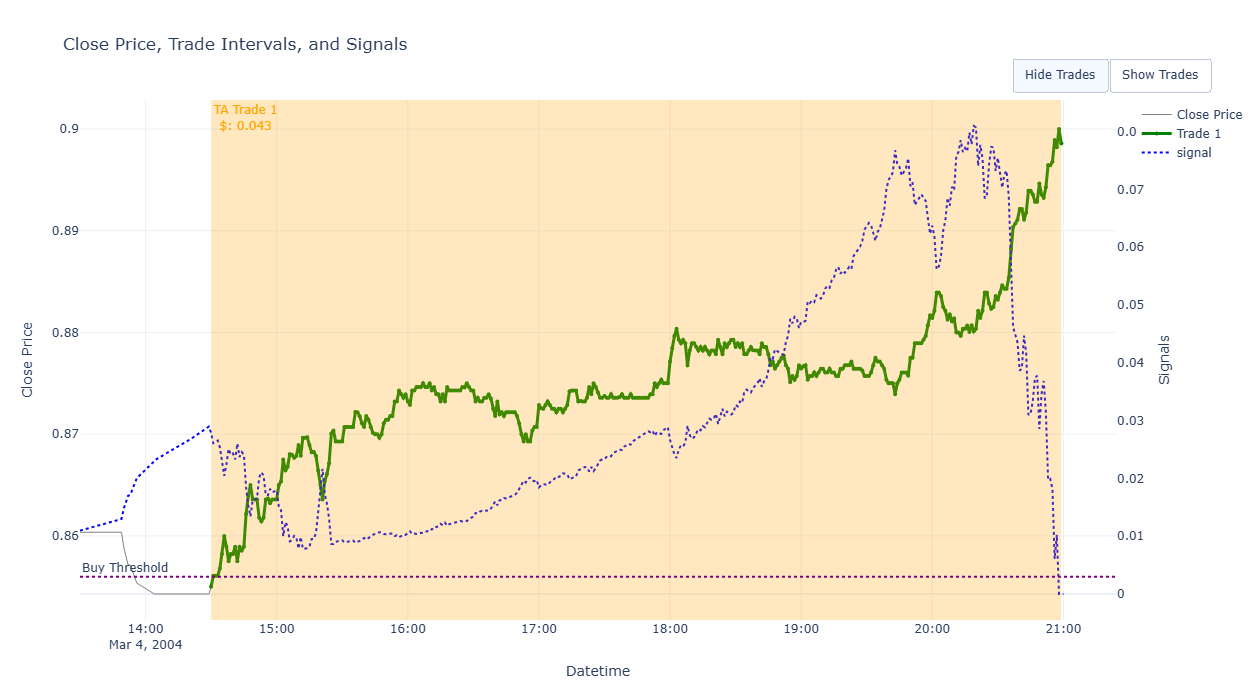


=== Performance for 2004-03-04 00:00:00 ===
Buy & Hold Return ($): 0.043
Strategy Return ($): 0.043
Trades Returns ($): [0.043]

=== Processing trading day 2004-03-05 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


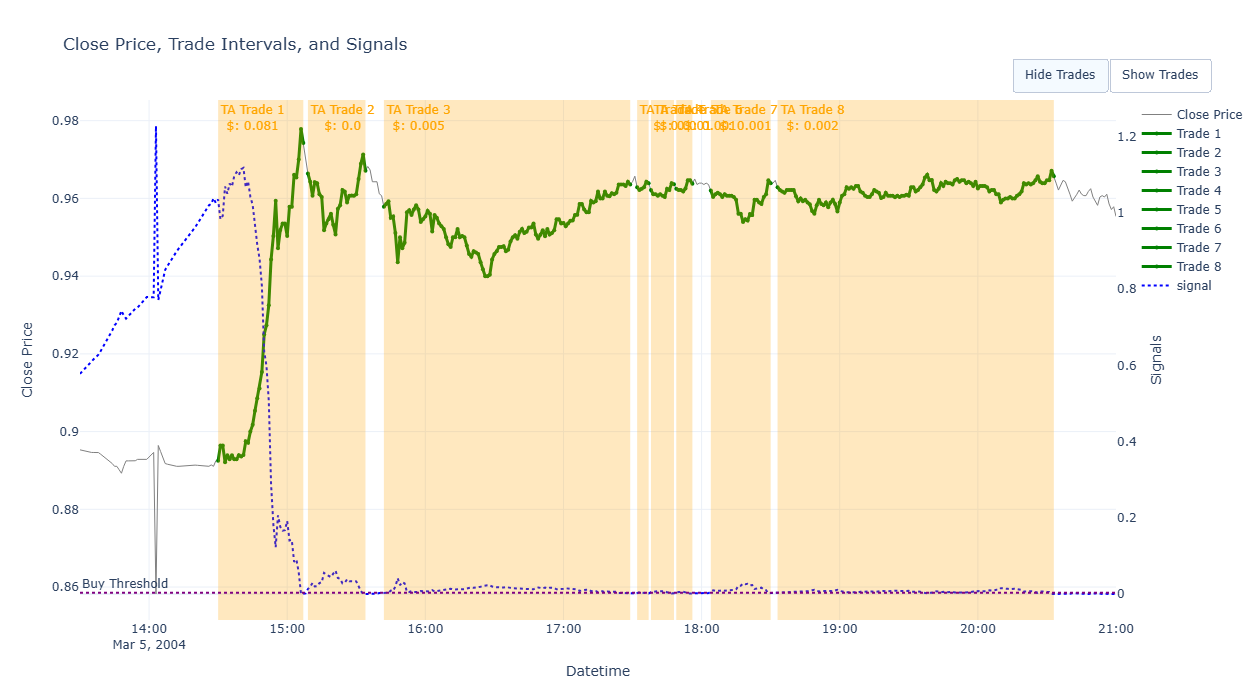


=== Performance for 2004-03-05 00:00:00 ===
Buy & Hold Return ($): 0.062
Strategy Return ($): 0.092
Trades Returns ($): [0.081, 0.0, 0.005, 0.0, 0.001, 0.001, 0.001, 0.002]

=== Processing trading day 2004-03-08 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


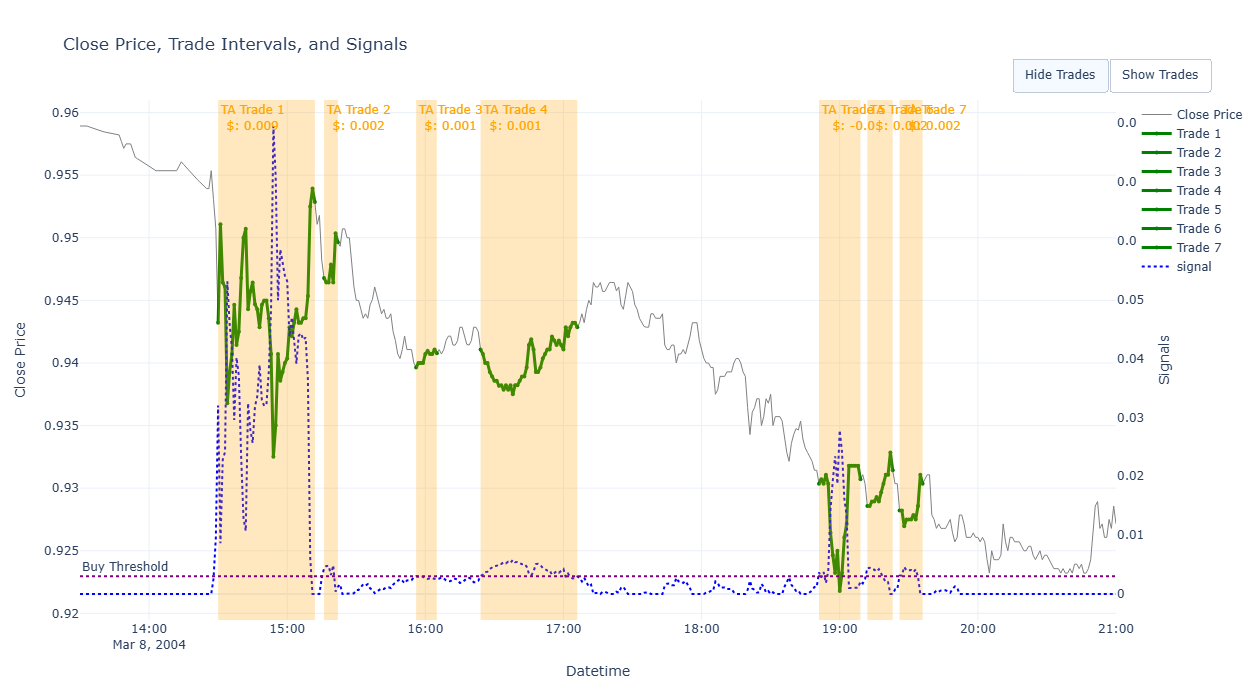


=== Performance for 2004-03-08 00:00:00 ===
Buy & Hold Return ($): -0.017
Strategy Return ($): 0.017
Trades Returns ($): [0.009, 0.002, 0.001, 0.001, -0.0, 0.002, 0.002]

=== Processing trading day 2004-03-09 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


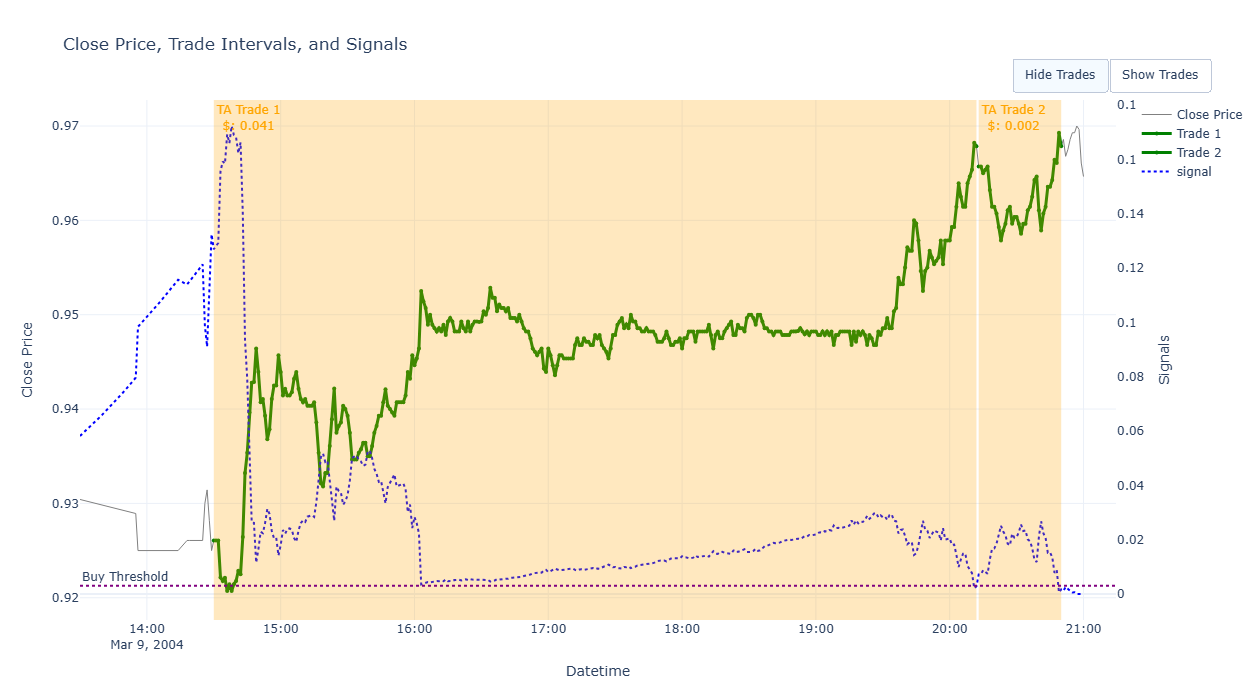


=== Performance for 2004-03-09 00:00:00 ===
Buy & Hold Return ($): 0.038
Strategy Return ($): 0.043
Trades Returns ($): [0.041, 0.002]

=== Processing trading day 2004-03-10 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


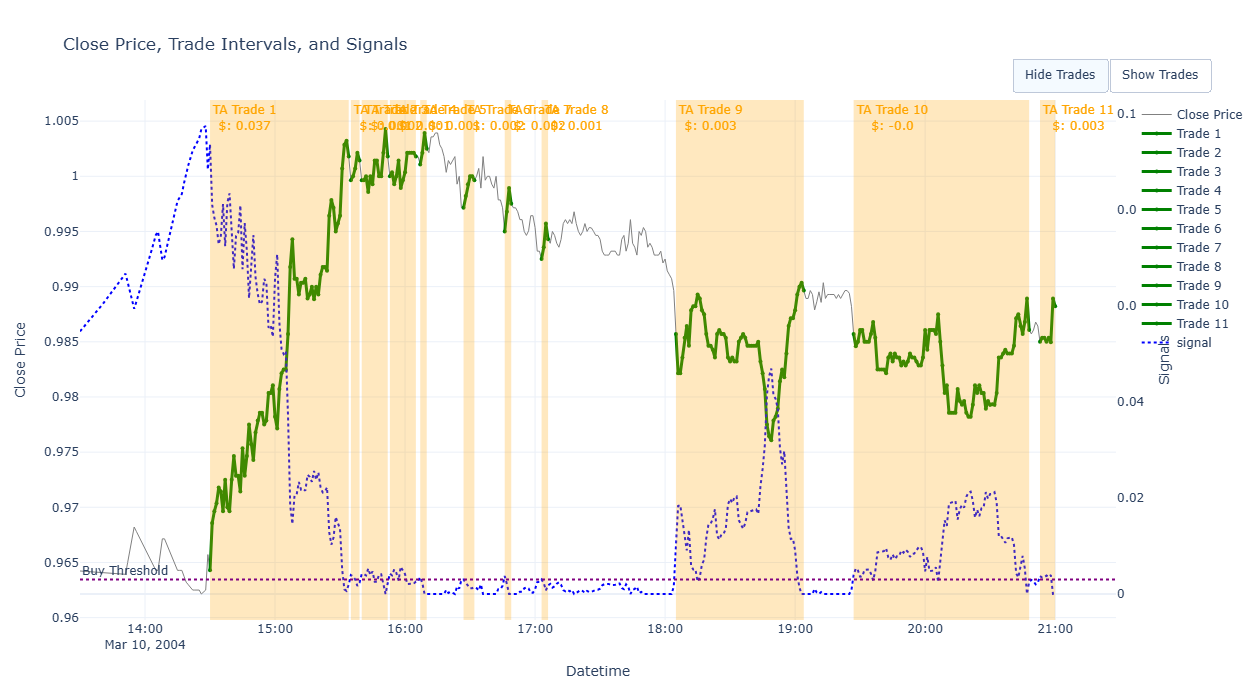


=== Performance for 2004-03-10 00:00:00 ===
Buy & Hold Return ($): 0.023
Strategy Return ($): 0.052
Trades Returns ($): [0.037, 0.001, 0.002, 0.001, 0.001, 0.002, 0.002, 0.001, 0.003, -0.0, 0.003]

=== Processing trading day 2004-03-11 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


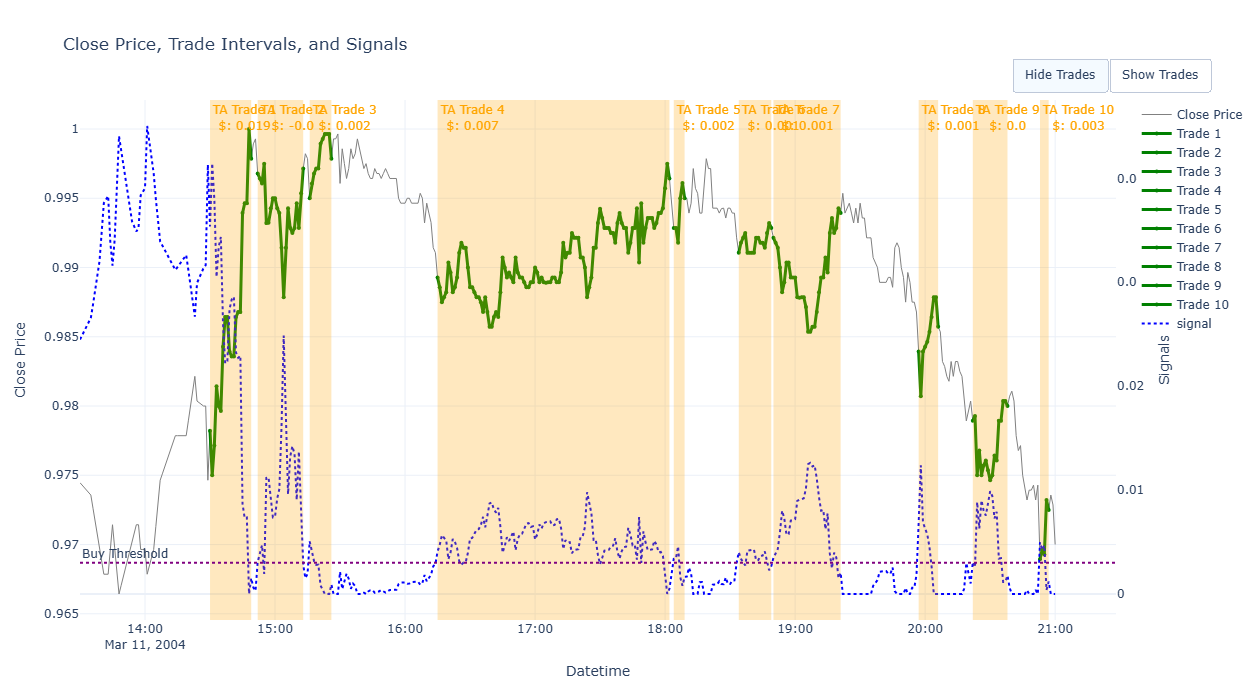


=== Performance for 2004-03-11 00:00:00 ===
Buy & Hold Return ($): -0.009
Strategy Return ($): 0.036
Trades Returns ($): [0.019, -0.0, 0.002, 0.007, 0.002, 0.001, 0.001, 0.001, 0.0, 0.003]

=== Processing trading day 2004-03-12 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


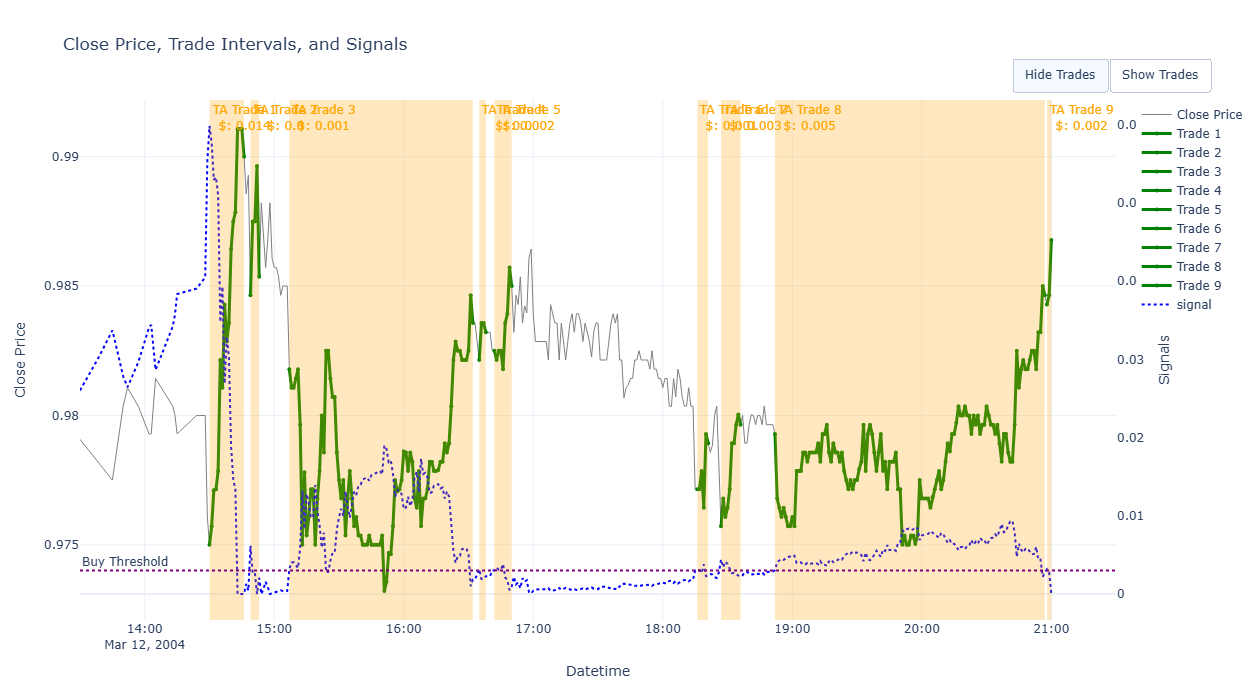


=== Performance for 2004-03-12 00:00:00 ===
Buy & Hold Return ($): 0.011
Strategy Return ($): 0.029
Trades Returns ($): [0.014, 0.0, 0.001, 0.0, 0.002, 0.001, 0.003, 0.005, 0.002]

=== Processing trading day 2004-03-15 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


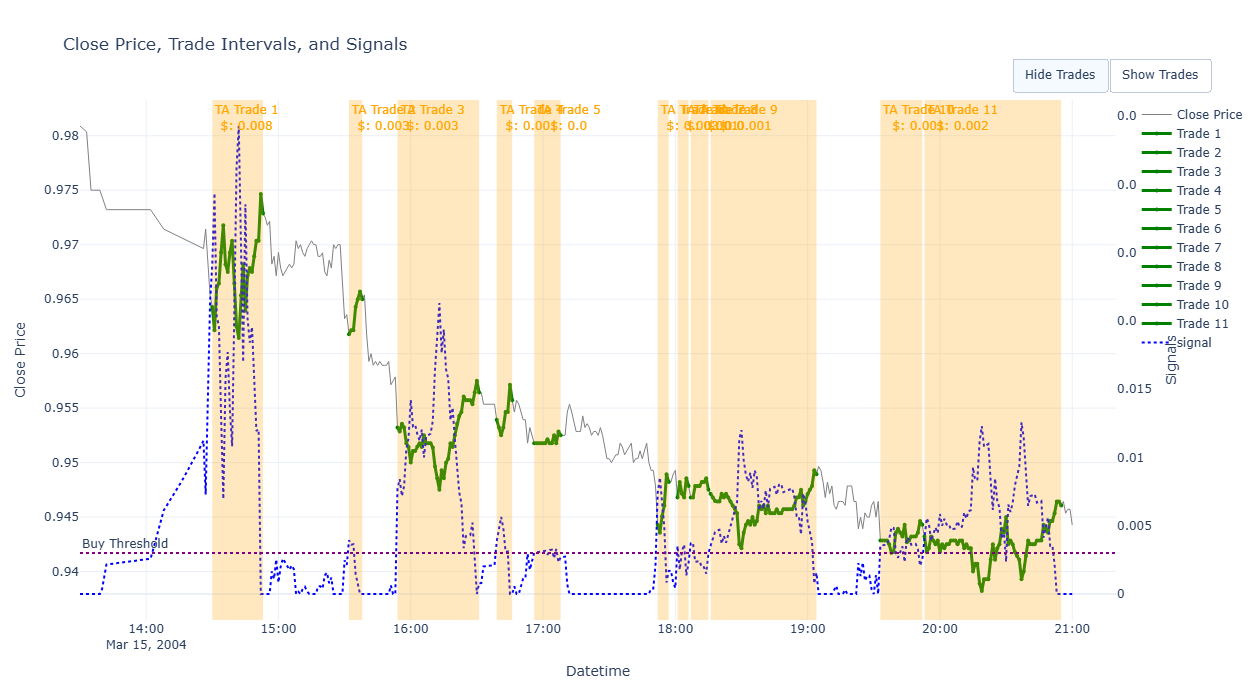


=== Performance for 2004-03-15 00:00:00 ===
Buy & Hold Return ($): -0.021
Strategy Return ($): 0.023
Trades Returns ($): [0.008, 0.003, 0.003, 0.001, 0.0, 0.003, 0.001, 0.0, 0.001, 0.001, 0.002]

=== Processing trading day 2004-03-16 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


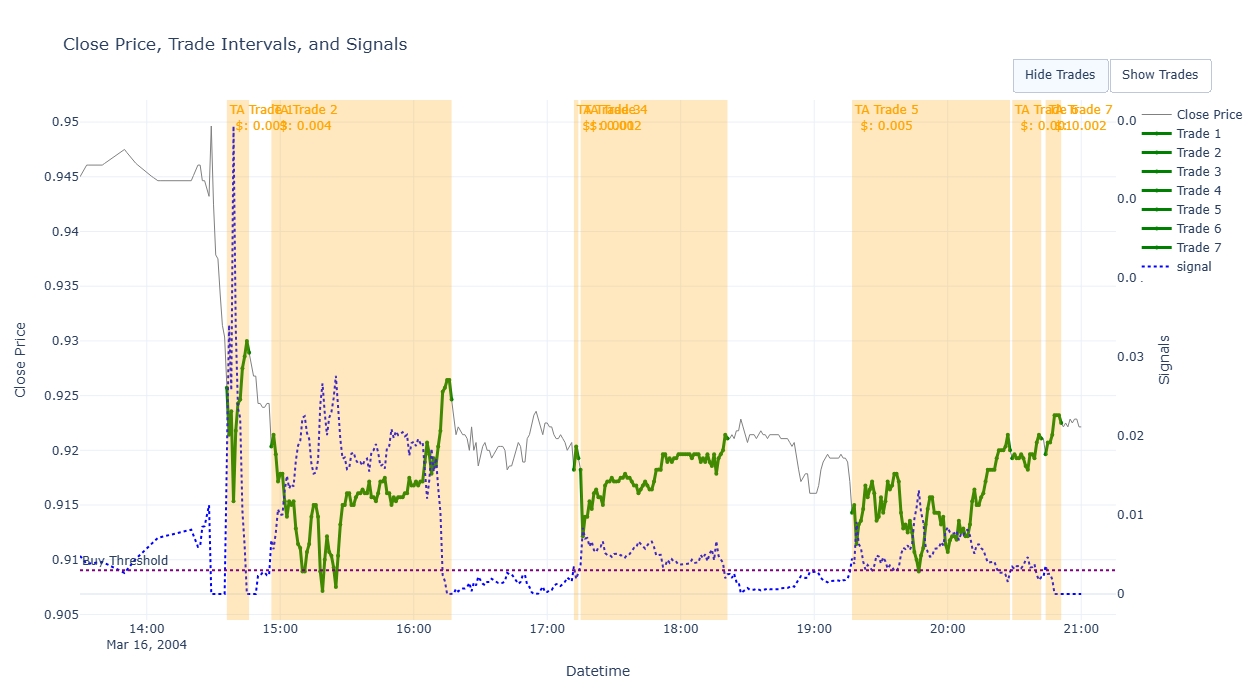


=== Performance for 2004-03-16 00:00:00 ===
Buy & Hold Return ($): -0.021
Strategy Return ($): 0.018
Trades Returns ($): [0.003, 0.004, 0.001, 0.002, 0.005, 0.001, 0.002]

=== Processing trading day 2004-03-17 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


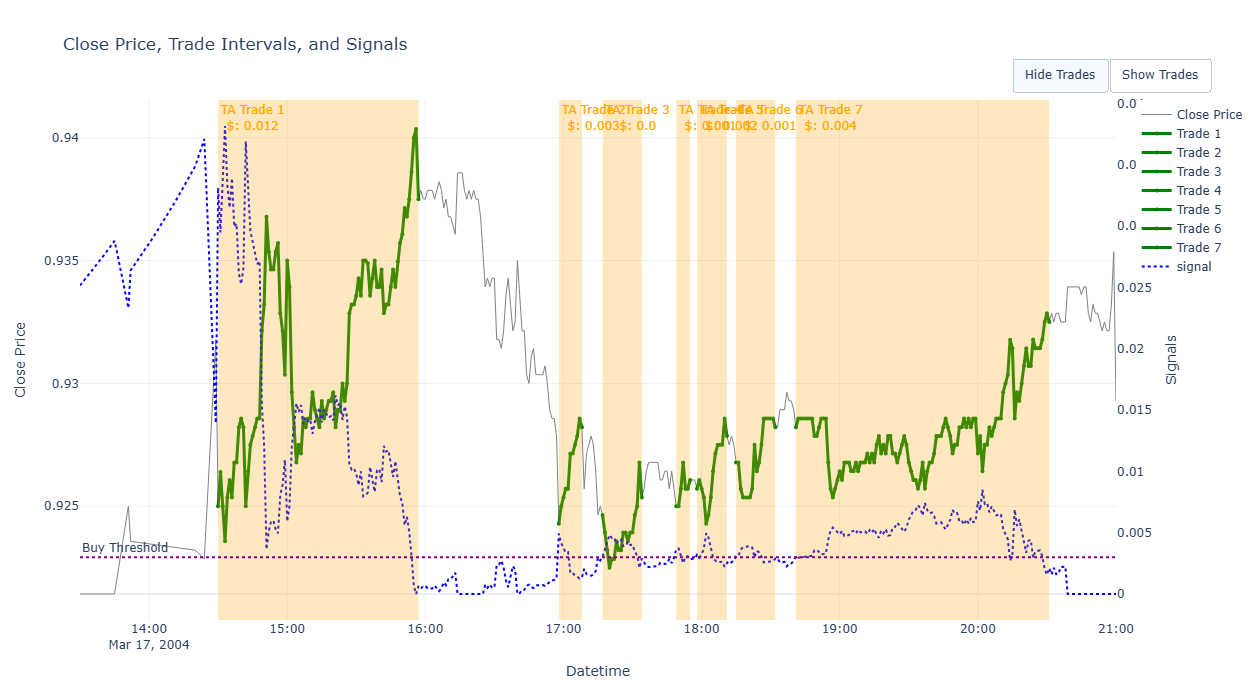


=== Performance for 2004-03-17 00:00:00 ===
Buy & Hold Return ($): 0.004
Strategy Return ($): 0.022
Trades Returns ($): [0.012, 0.003, 0.0, 0.001, 0.002, 0.001, 0.004]

=== Processing trading day 2004-03-18 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


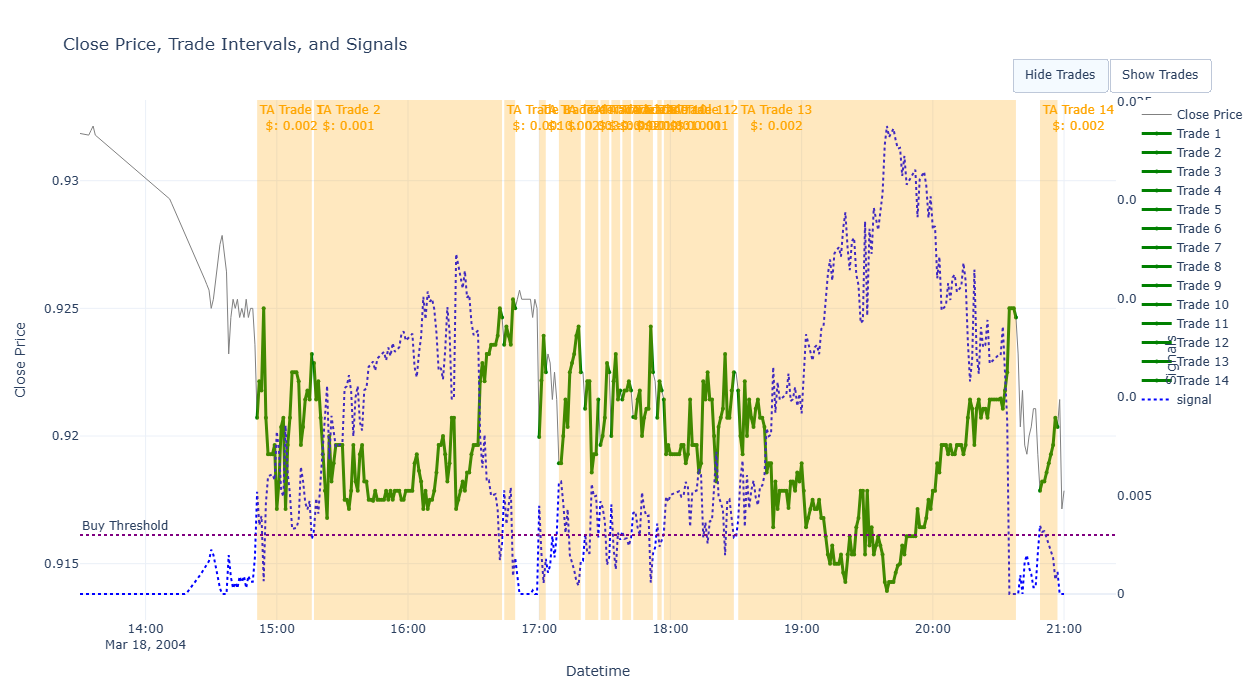


=== Performance for 2004-03-18 00:00:00 ===
Buy & Hold Return ($): -0.008
Strategy Return ($): 0.019
Trades Returns ($): [0.002, 0.001, 0.001, 0.002, 0.003, -0.0, 0.002, 0.001, -0.0, 0.001, 0.001, 0.001, 0.002, 0.002]

=== Processing trading day 2004-03-19 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


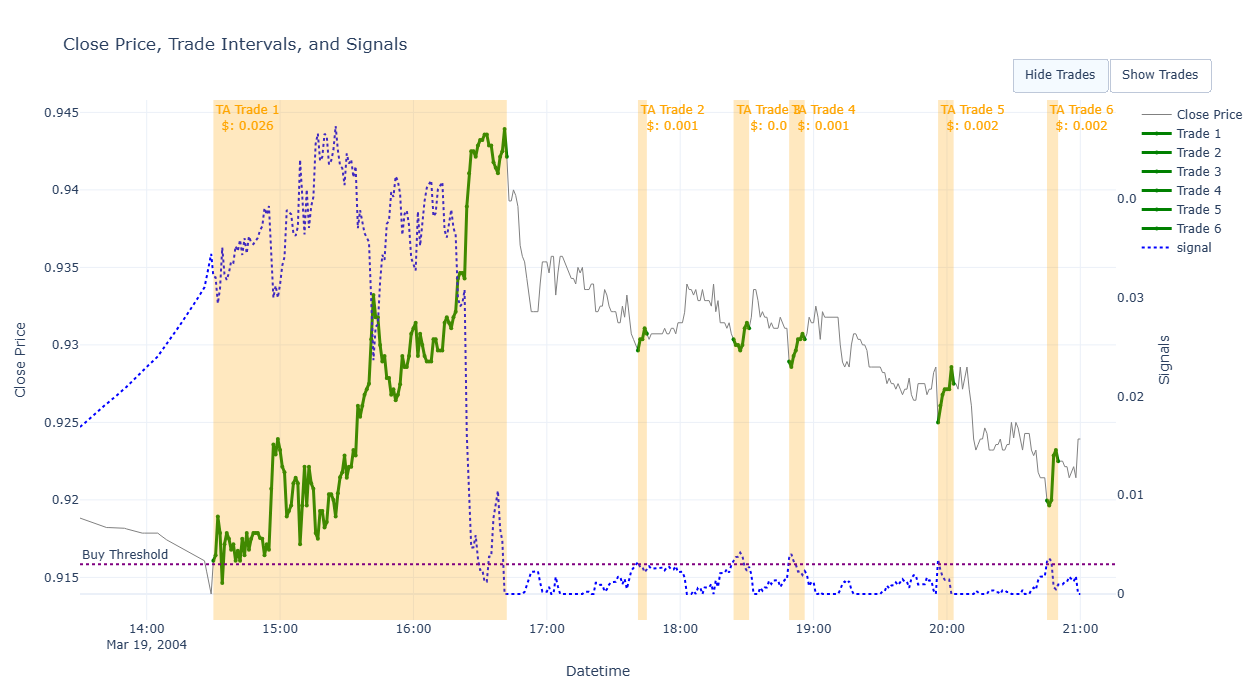


=== Performance for 2004-03-19 00:00:00 ===
Buy & Hold Return ($): 0.007
Strategy Return ($): 0.031
Trades Returns ($): [0.026, 0.001, 0.0, 0.001, 0.002, 0.002]

=== Processing trading day 2004-03-22 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


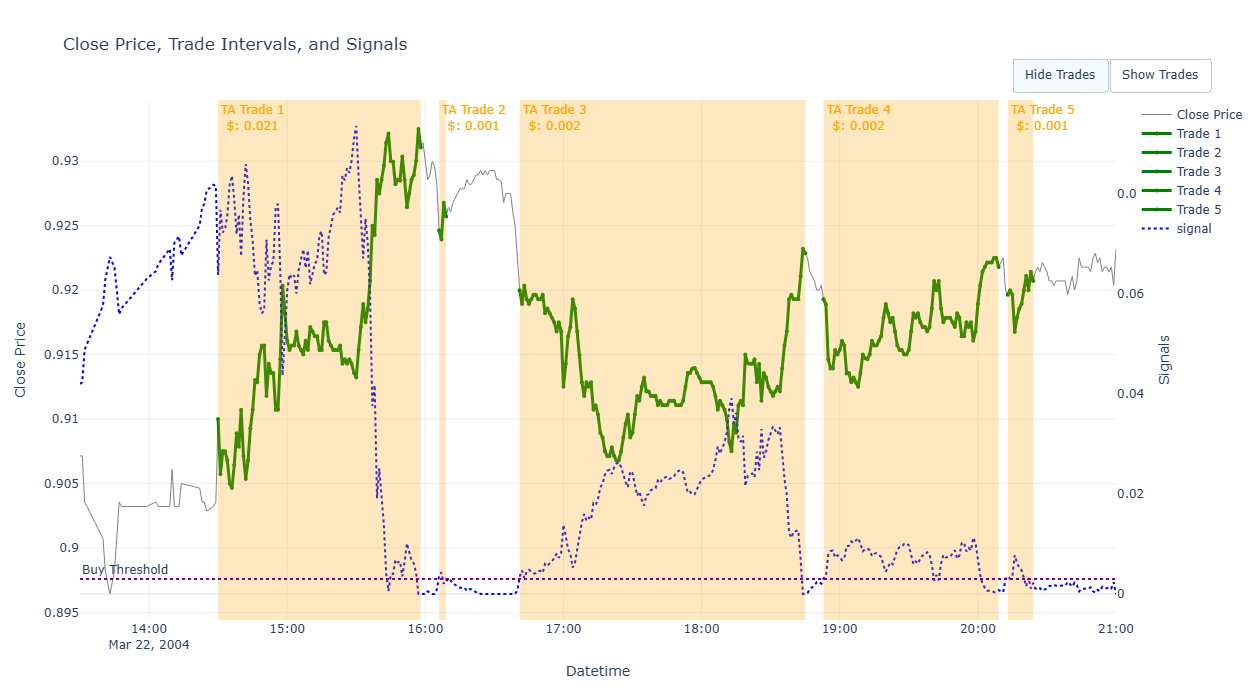


=== Performance for 2004-03-22 00:00:00 ===
Buy & Hold Return ($): 0.013
Strategy Return ($): 0.026
Trades Returns ($): [0.021, 0.001, 0.002, 0.002, 0.001]

=== Processing trading day 2004-03-23 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


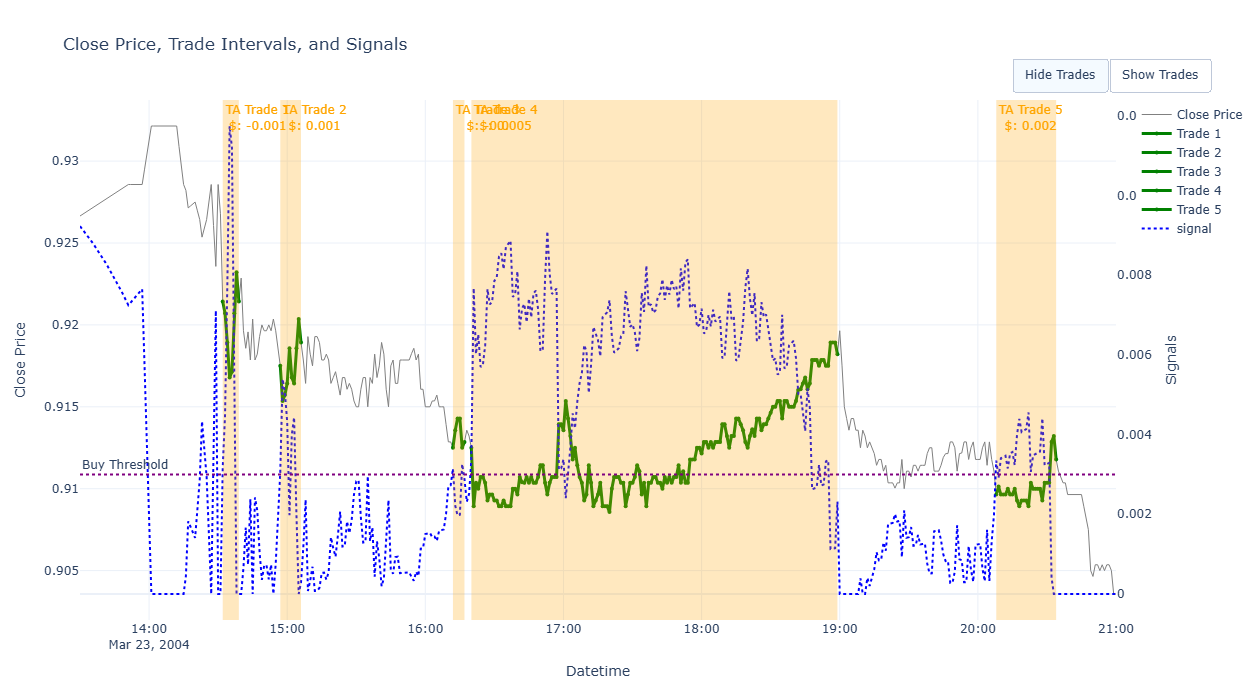


=== Performance for 2004-03-23 00:00:00 ===
Buy & Hold Return ($): -0.026
Strategy Return ($): 0.007
Trades Returns ($): [-0.001, 0.001, -0.0, 0.005, 0.002]

=== Processing trading day 2004-03-24 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


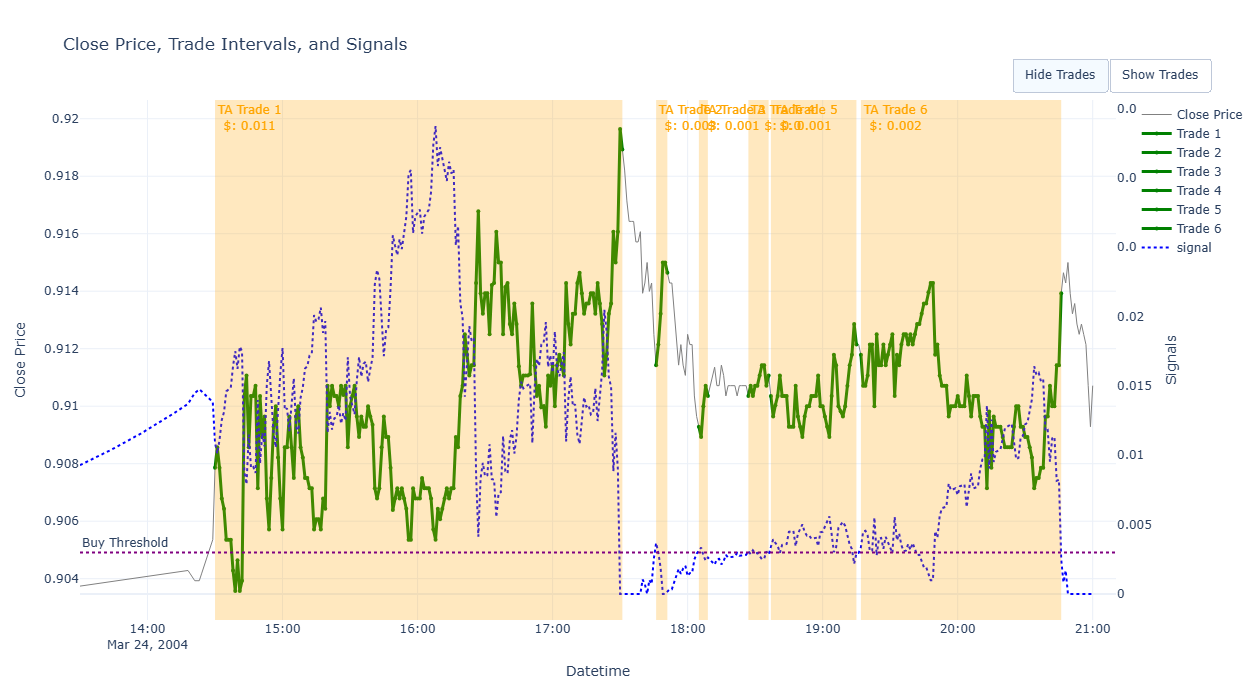


=== Performance for 2004-03-24 00:00:00 ===
Buy & Hold Return ($): 0.002
Strategy Return ($): 0.017
Trades Returns ($): [0.011, 0.003, 0.001, 0.0, 0.001, 0.002]

=== Processing trading day 2004-03-25 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


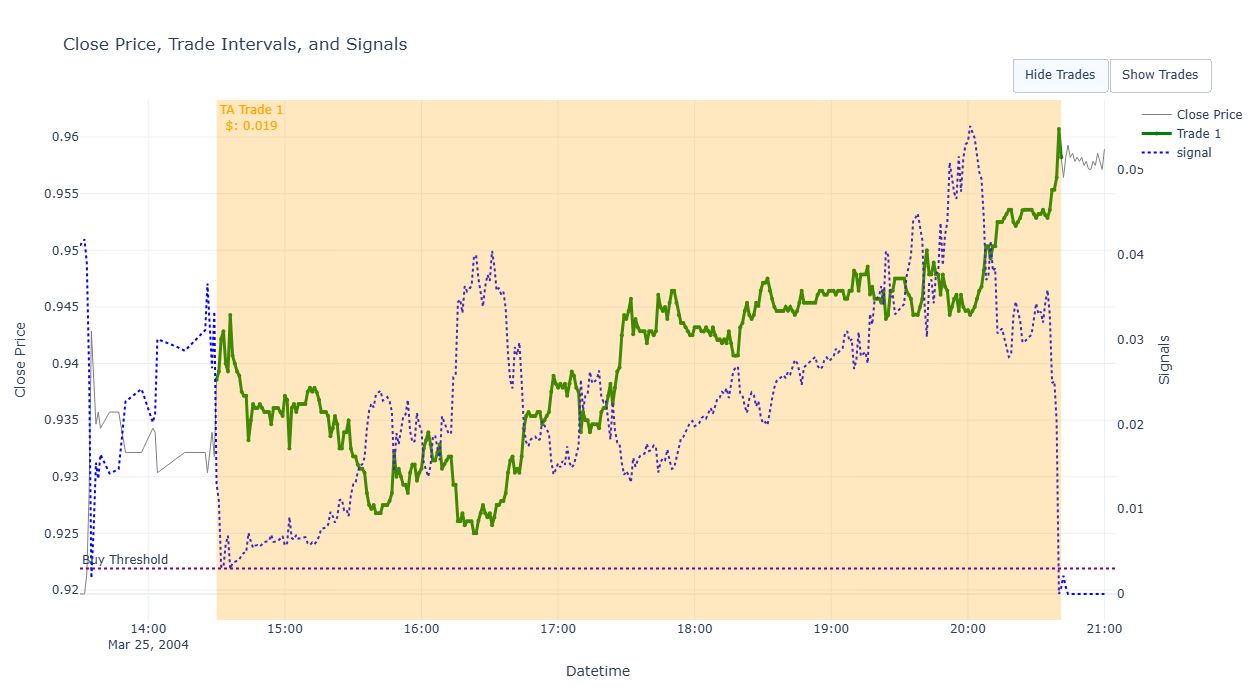


=== Performance for 2004-03-25 00:00:00 ===
Buy & Hold Return ($): 0.02
Strategy Return ($): 0.019
Trades Returns ($): [0.019]

=== Processing trading day 2004-03-26 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


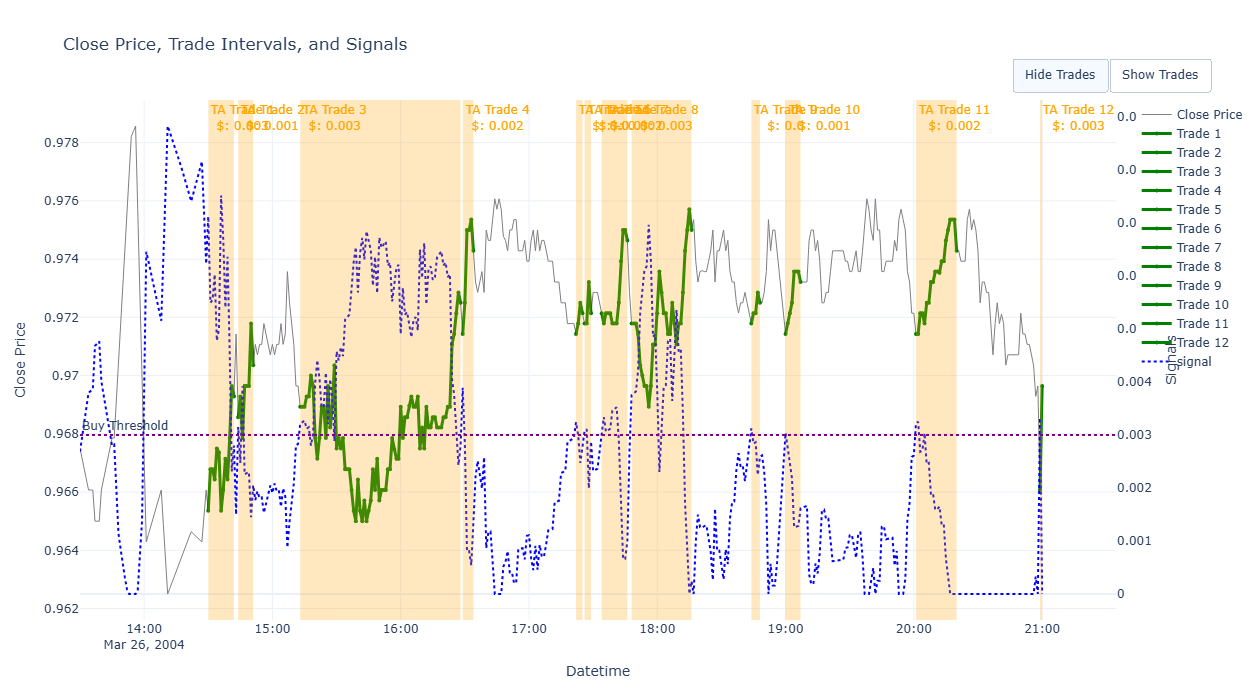


=== Performance for 2004-03-26 00:00:00 ===
Buy & Hold Return ($): 0.004
Strategy Return ($): 0.021
Trades Returns ($): [0.003, 0.001, 0.003, 0.002, 0.0, -0.0, 0.002, 0.003, 0.0, 0.001, 0.002, 0.003]

=== Processing trading day 2004-03-29 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


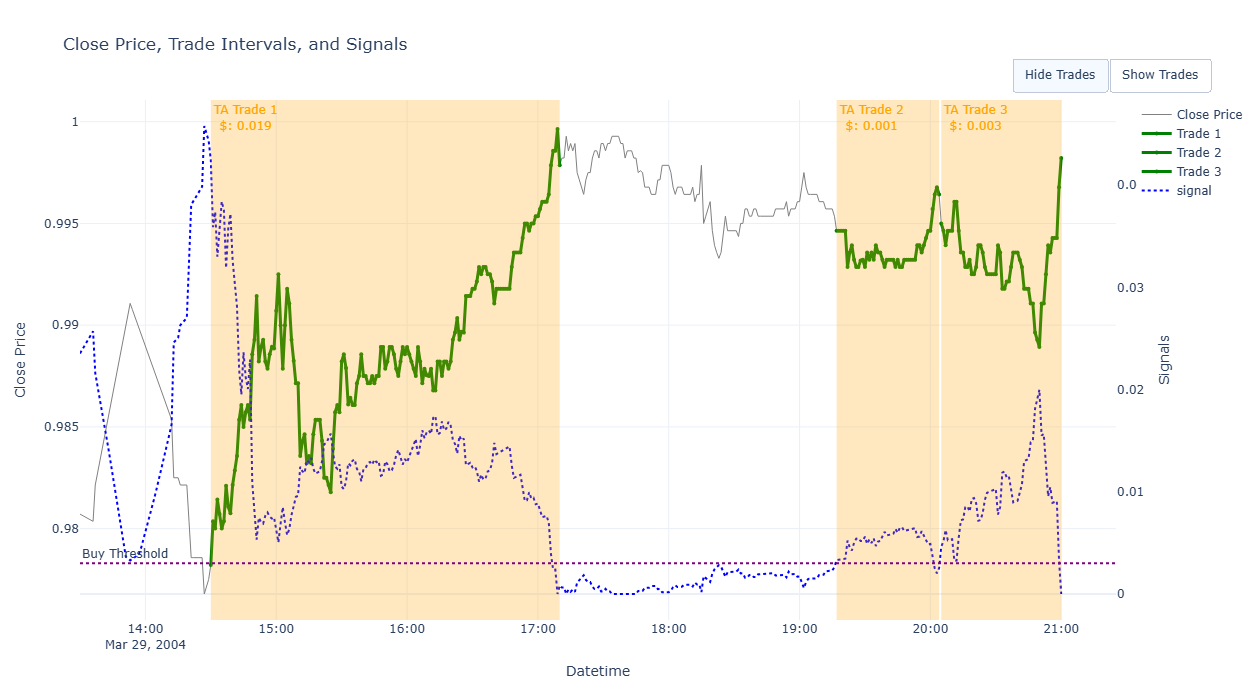


=== Performance for 2004-03-29 00:00:00 ===
Buy & Hold Return ($): 0.019
Strategy Return ($): 0.023
Trades Returns ($): [0.019, 0.001, 0.003]

=== Processing trading day 2004-03-30 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


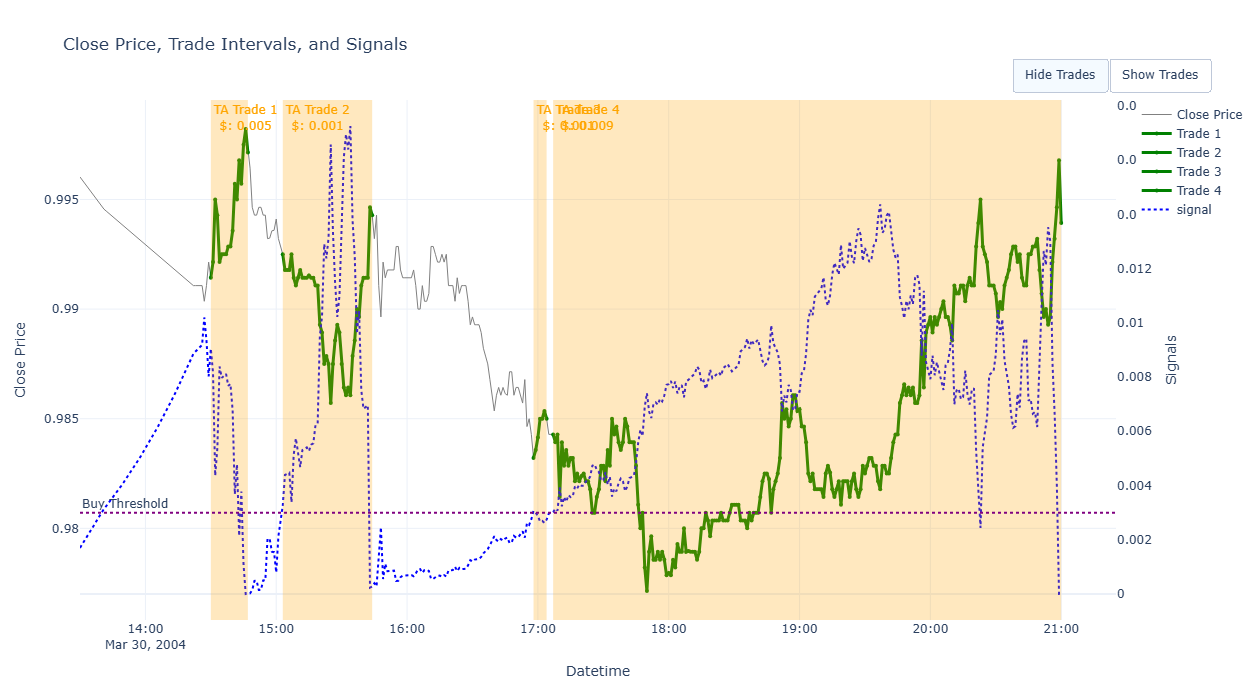


=== Performance for 2004-03-30 00:00:00 ===
Buy & Hold Return ($): 0.002
Strategy Return ($): 0.017
Trades Returns ($): [0.005, 0.001, 0.001, 0.009]

=== Processing trading day 2004-03-31 ===

 Running trading pipeline on selected date …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …


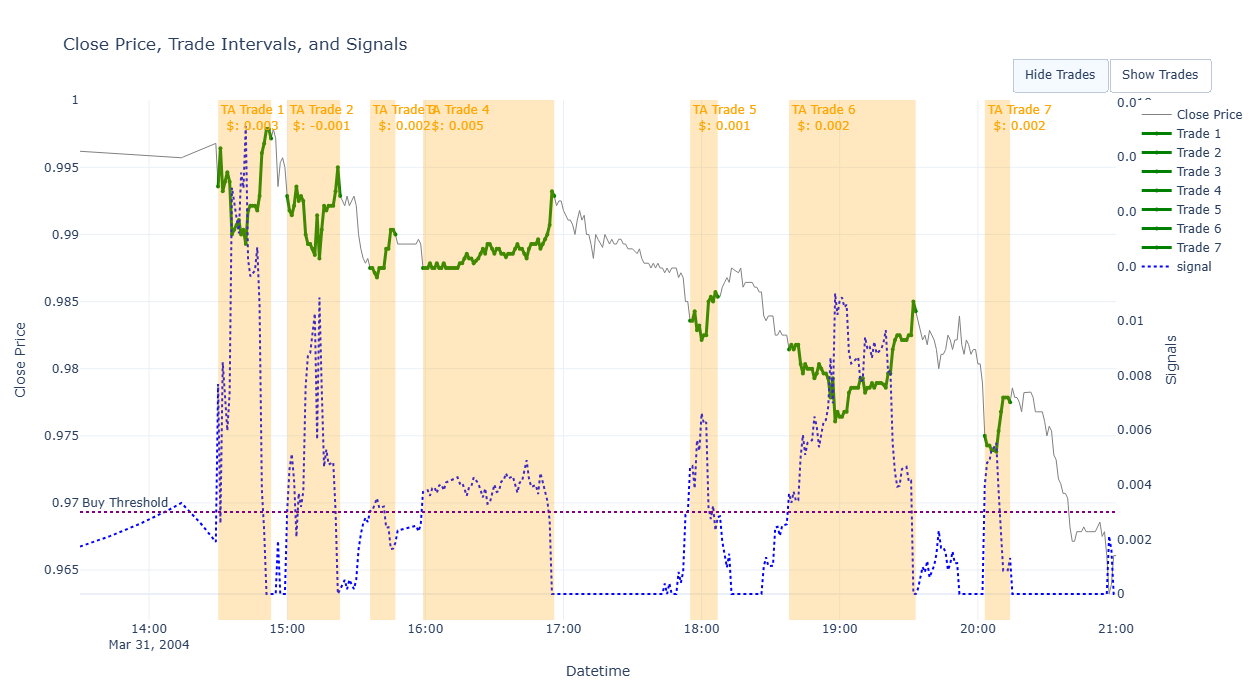


=== Performance for 2004-03-31 00:00:00 ===
Buy & Hold Return ($): -0.028
Strategy Return ($): 0.014
Trades Returns ($): [0.003, -0.001, 0.002, 0.005, 0.001, 0.002, 0.002]

Overall Summary (2004-03-01 = 0.8645 → 2004-03-31 = 0.9658)

One-time buy&hold gain: 0.101
Buy & Hold – each day ($): 0.114
Strategy Return ($): 0.603
Trades Count: 151
Strategy return per trade: 0.004
Num. trading days: 23
Strategy return per trading day: 0.026


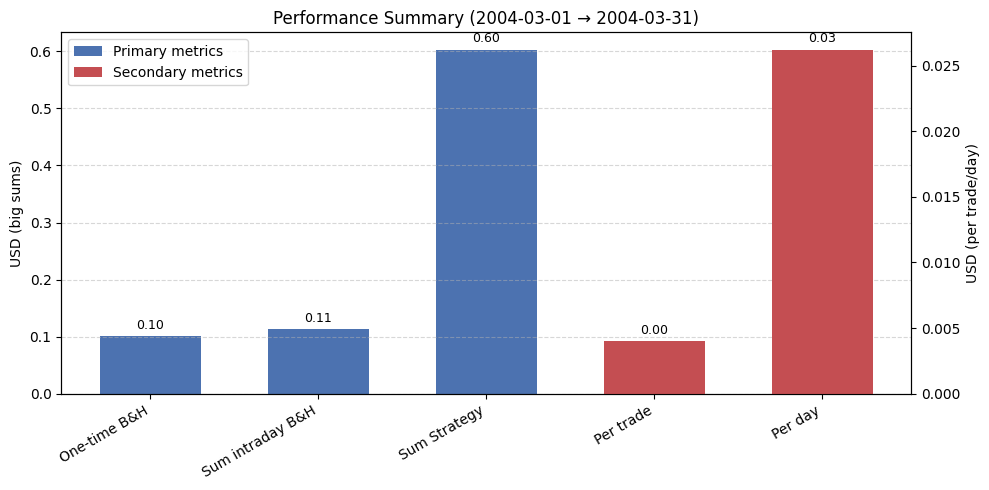


Full-run mode

•Running trading pipeline on full dataset …
Identify_trades_daily …
Add_trade_signal_to_results …
Simulate_trading …

•Merging, concatenating all days, and calculating test performances …

Overall Summary (2004-01-02 = 0.7727 → 2025-06-18 = 196.4810)

One-time buy&hold gain: 195.708
Buy & Hold – each day ($): -120.852
Strategy Return ($): 3645.721
Trades Count: 24072
Strategy return per trade: 0.151
Num. trading days: 5395
Strategy return per trading day: 0.676


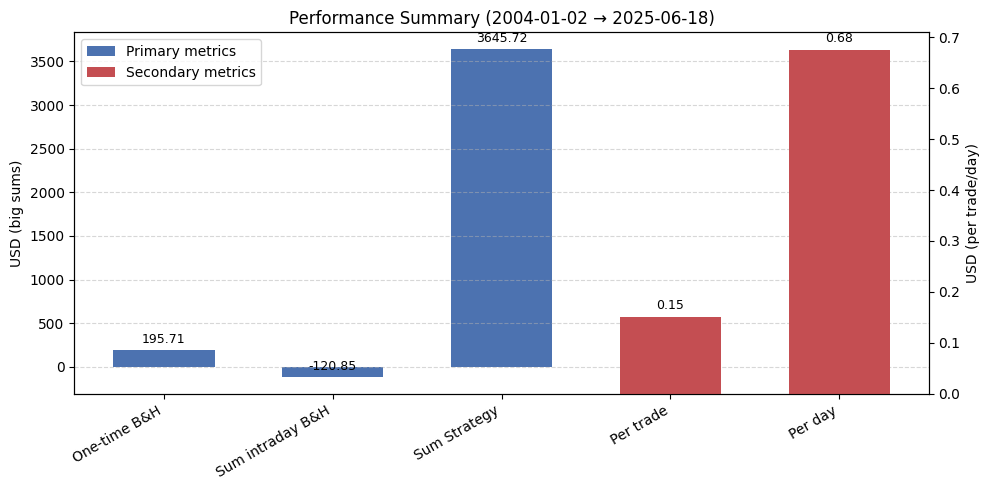


Overall Summary (2022-03-29 = 176.9931 → 2025-06-18 = 196.4810)

One-time buy&hold gain: 19.488
Buy & Hold – each day ($): -57.699
Strategy Return ($): 1838.146
Trades Count: 3441
Strategy return per trade: 0.534
Num. trading days: 809
Strategy return per trading day: 2.272


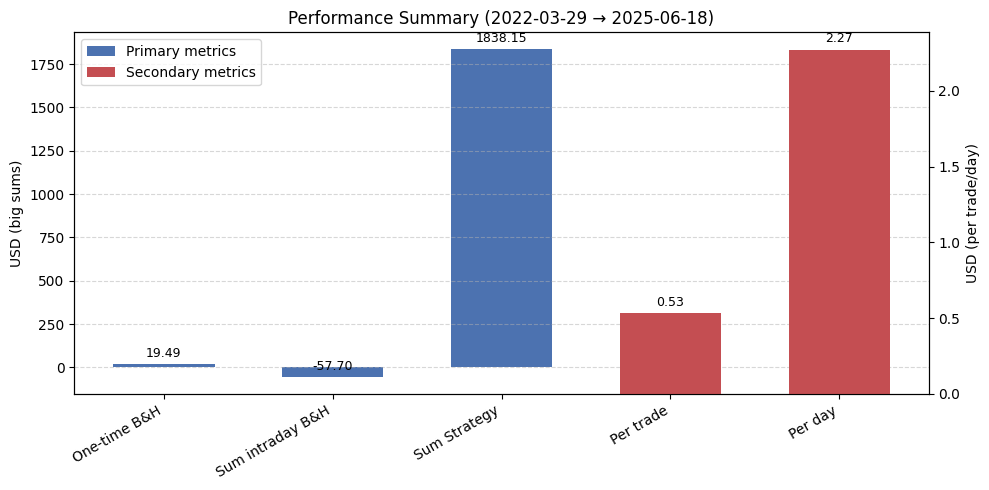


•Saving CSV …
Saved to dfs_training/AAPL_2_ready.csv


open        high         low       close  \
2004-01-02 12:30:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 12:31:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 12:32:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 12:33:00    0.764286    0.764286    0.764286    0.764286   
2004-01-02 12:34:00    0.764286    0.764286    0.764286    0.764286   
...                         ...         ...         ...         ...   
2025-06-18 20:56:00  196.680000  196.860000  196.630000  196.815000   
2025-06-18 20:57:00  196.810000  196.940000  196.560000  196.675000   
2025-06-18 20:58:00  196.675000  196.740000  196.630000  196.670000   
2025-06-18 20:59:00  196.680000  196.750000  196.240000  196.240000   
2025-06-18 21:00:00  196.580000  196.650000  196.080000  196.540000   

                         volume         bid         ask  StrategyEarning  \
2004-01-02 12:30:00     28000.0    0.764057    0.764514            0.000   
2004-01-02 12:31:00     28000.0    0.764057    0.764514            0.000   
2004-01-02 12:32:00     28000.0    0.764057    0.764514            0.000   
2004-01-02 12:33:00     28000.0    0.764057    0.764514            0.000   
2004-01-02 12:34:00     28000.0    0.764057    0.764514            0.000   
...                         ...         ...         ...              ...   
2025-06-18 20:56:00    385695.0  196.756000  196.874000            2.608   
2025-06-18 20:57:00    460630.0  196.616000  196.734000            2.608   
2025-06-18 20:58:00    525245.0  196.611000  196.729000            2.608   
2025-06-18 20:59:00   2075503.0  196.181100  196.298900            2.608   
2025-06-18 21:00:00  15600625.0  196.481000  196.599000            2.608   

                     EarningDiff    signal  signal_action  
2004-01-02 12:30:00        0.000  0.024405              0  
2004-01-02 12:31:00        0.000  0.024626              0  
2004-01-02 12:32:00        0.000  0.024848              0  
2004-01-02 12:33:00        0.000  0.025073              0  
2004-01-02 12:34:00        0.000  0.025300              0  
...                          ...       ...            ...  
2025-06-18 20:56:00        1.831  0.000000              0  
2025-06-18 20:57:00        1.971  0.000000              0  
2025-06-18 20:58:00        1.976  0.000000              0  
2025-06-18 20:59:00        2.406  0.000000              0  
2025-06-18 21:00:00        2.106  0.000000              0  

[2756845 rows x 11 columns]

In [6]:
df_fin = saveDF_checkDAY(
                        df=df,
                        ticker=params.ticker,
                        min_prof_thr=params.min_prof_thr_tick, 
                        max_down_prop=params.max_down_prop_tick, 
                        gain_tightening_factor=params.gain_tightening_factor_tick,
                        smooth_win_sig=params.smooth_win_sig_tick, 
                        pre_entry_decay=params.pre_entry_decay_tick, 
                        buy_threshold=params.buy_threshold_tick, 
                        trailing_stop_thresh=params.trailing_stop_thresh_tick,
                        merging_retracement_thr=params.merging_retracement_thr_tick, 
                        merging_time_gap_thr=params.merging_time_gap_thr_tick
                        )

df_fin


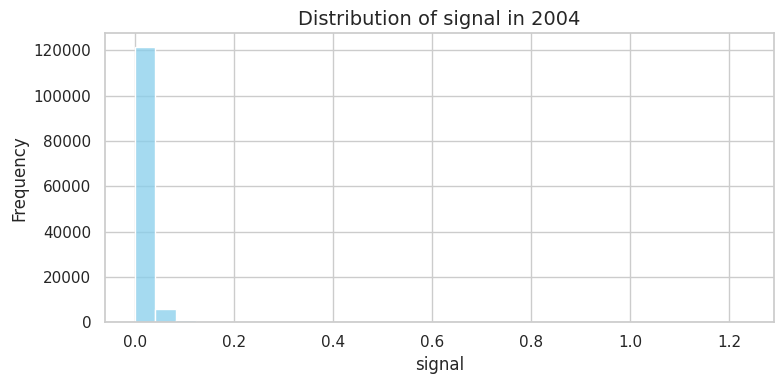

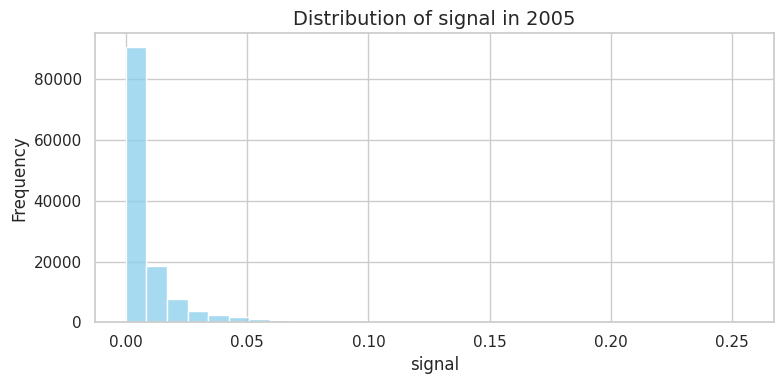

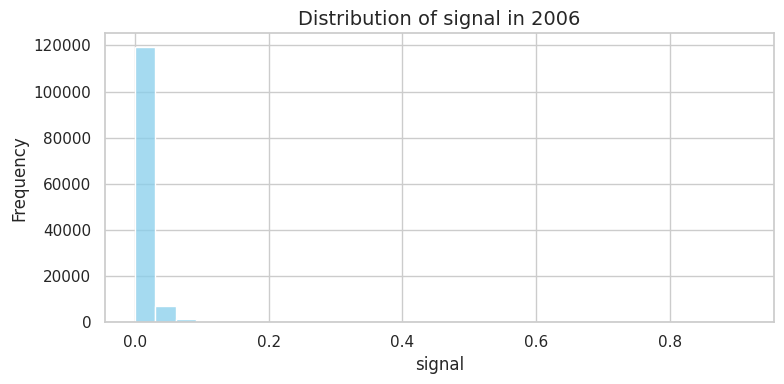

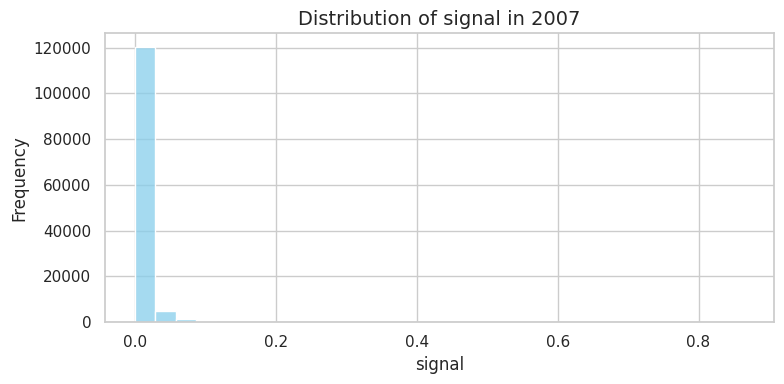

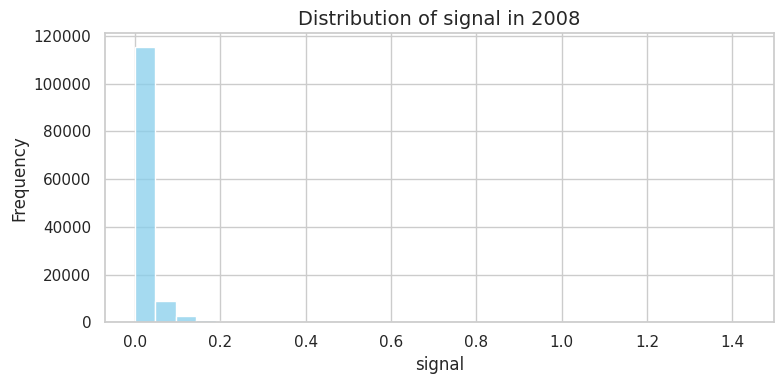

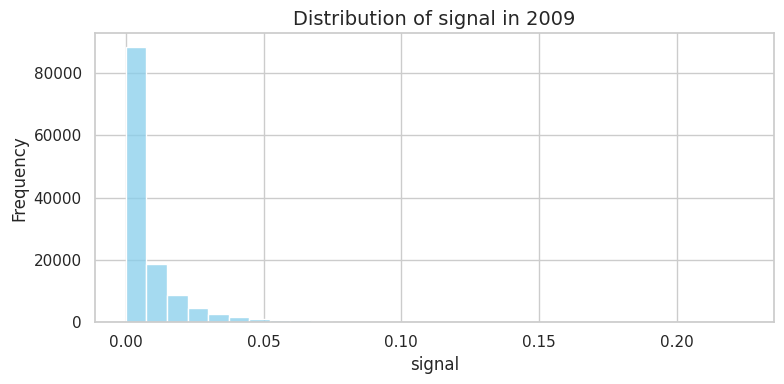

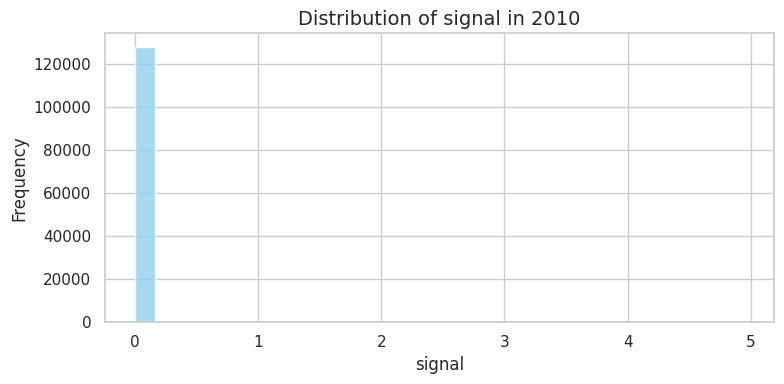

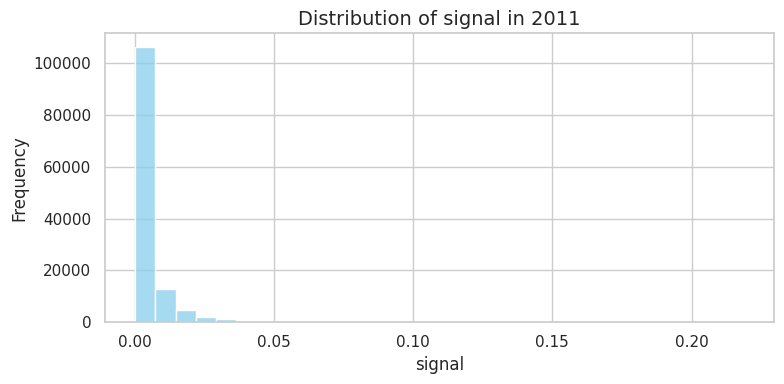

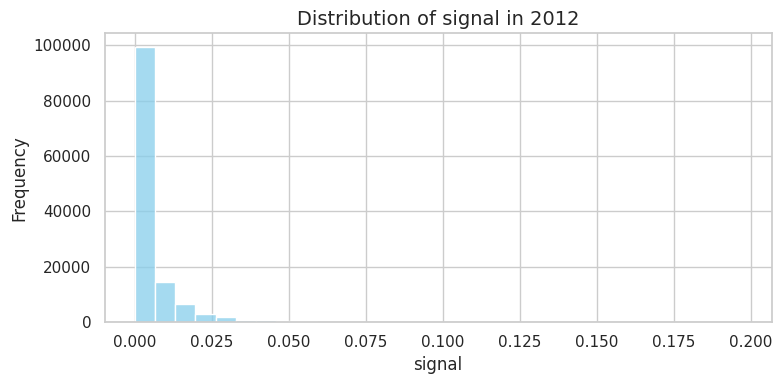

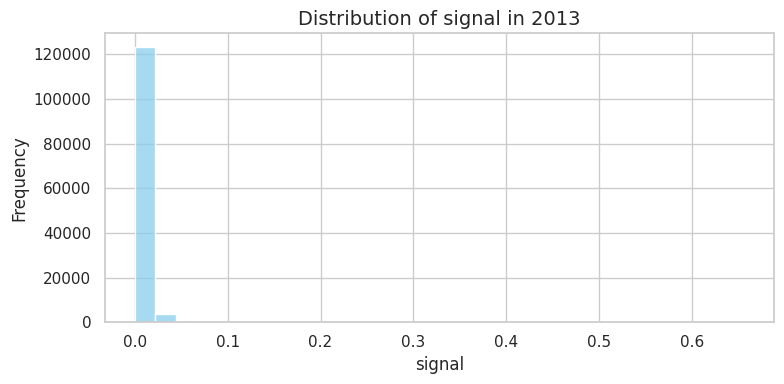

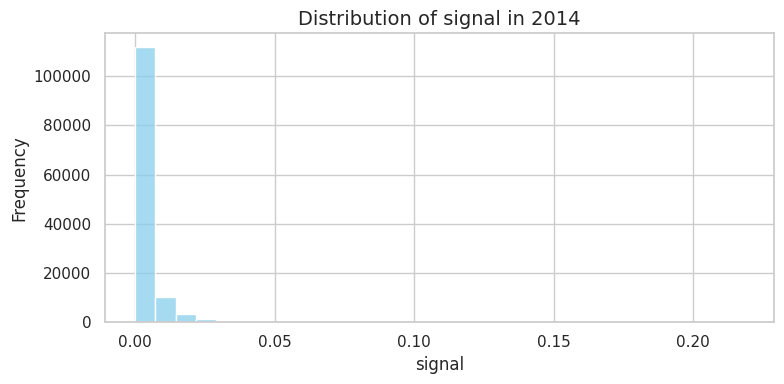

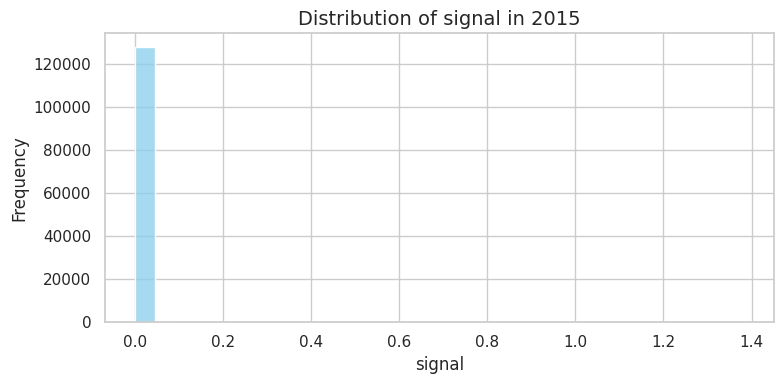

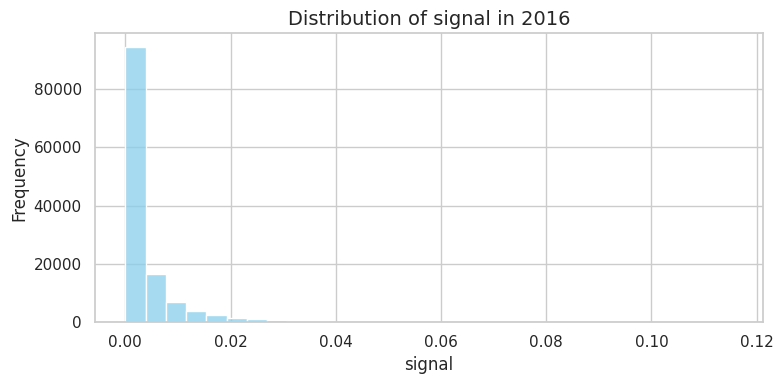

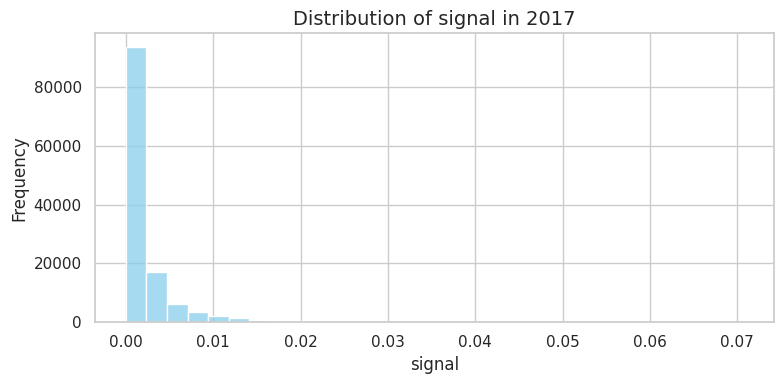

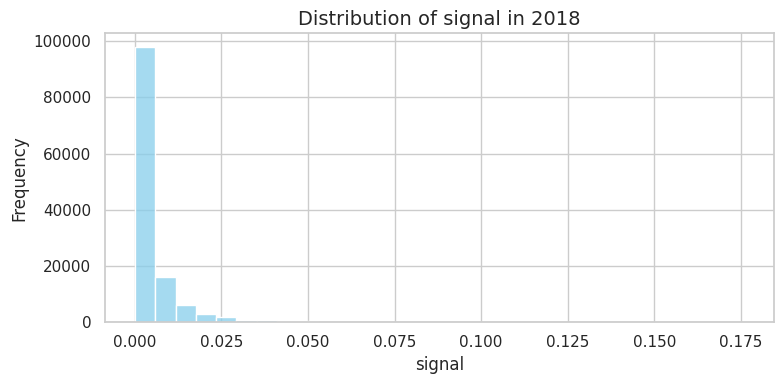

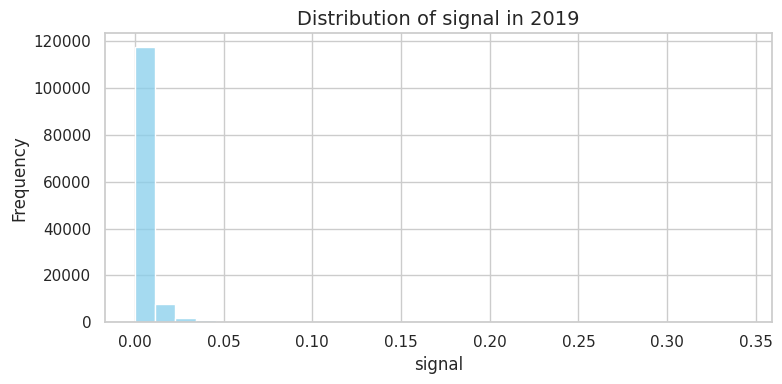

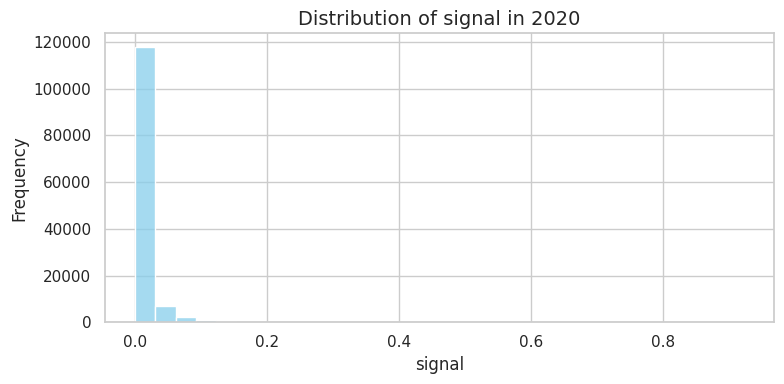

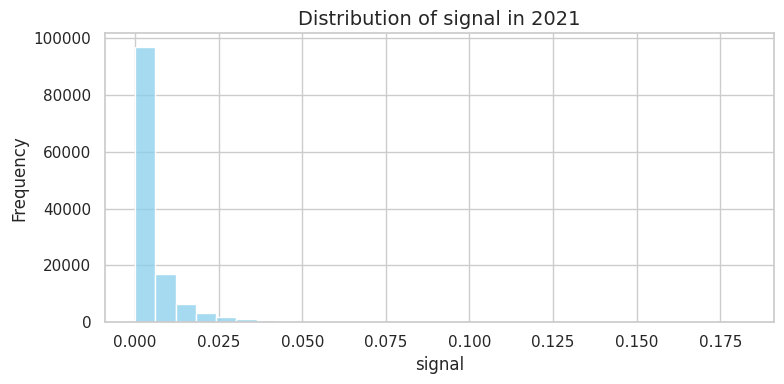

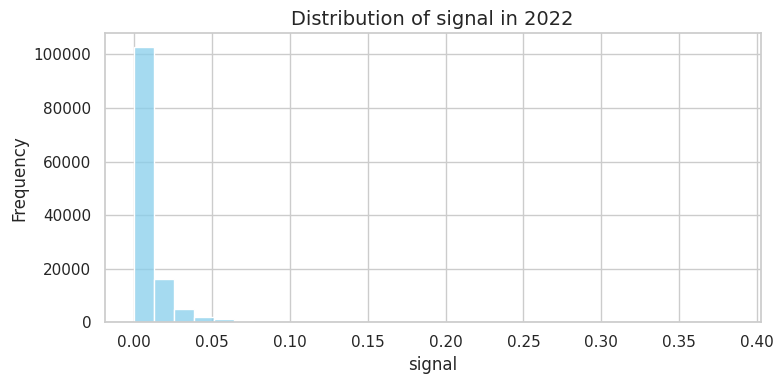

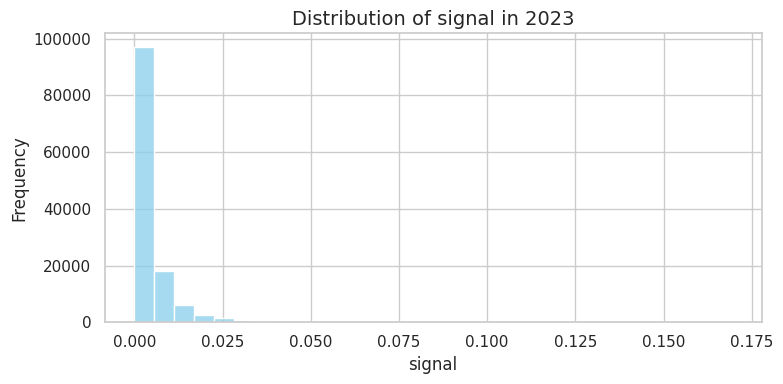

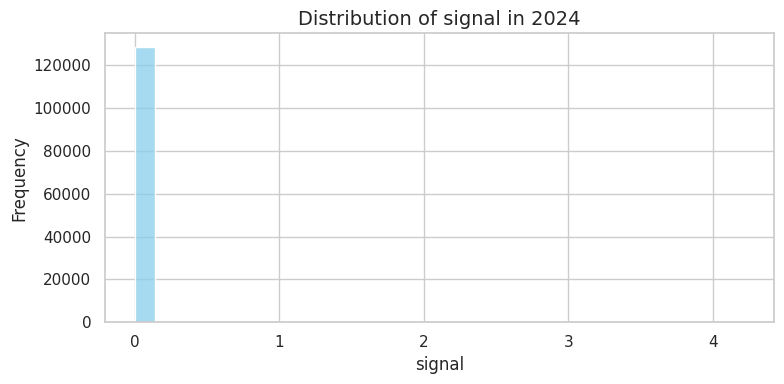

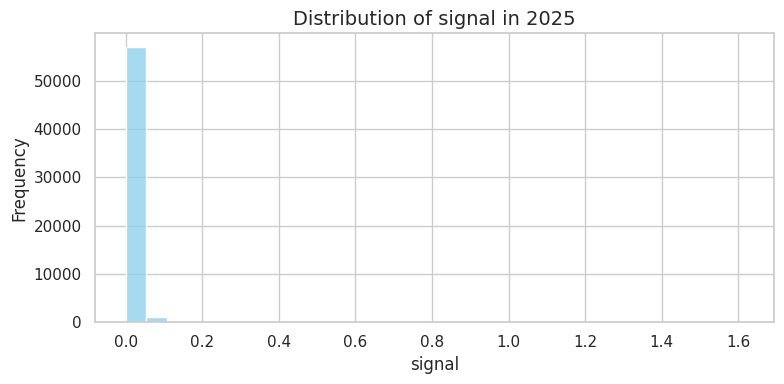

signal_min  signal_max  signal_mean  signal_median  close_return
2004-01         0.0    0.176172     0.012933       0.005336      0.170916
2004-02         0.0    0.113360     0.009454       0.004511      0.105893
2004-03         0.0    1.228527     0.019479       0.005293      0.196335
2004-04         0.0    0.264598     0.009778       0.004320      0.156863
2004-05         0.0    0.095605     0.012528       0.006421      0.127743
...             ...         ...          ...            ...           ...
2025-02         0.0    0.124495     0.007832       0.002995      0.105627
2025-03         0.0    0.090358     0.008604       0.004176      0.168574
2025-04         0.0    1.612922     0.046143       0.007982      0.338585
2025-05         0.0    0.216442     0.006348       0.002752      0.109857
2025-06         0.0    0.055658     0.003740       0.001690      0.055630

[258 rows x 5 columns]

In [7]:
# Group by month
period = df_fin.index.to_period('M')

# Monthly stats for signal
signal_stats = df_fin.groupby(period)['signal'].agg(
    signal_min='min',
    signal_max='max',
    signal_mean='mean',
    signal_median='median'
)

# Monthly close return: (max - min) / min
close_return = df_fin.groupby(period)['close'].agg(
    close_return=lambda x: np.nan if x.min() == 0 else (x.max() - x.min()) / x.min()
)

# Combine into one DataFrame
monthly_stats = signal_stats.join(close_return)


# --------------------------------------------------
# Now plot histograms of signal for each year
# --------------------------------------------------

sns.set(style="whitegrid")
unique_years = sorted(df_fin.index.year.unique())

for y in unique_years:
    subset = df_fin[df_fin.index.year == y]['signal']
    
    plt.figure(figsize=(8, 4))
    sns.histplot(subset, bins=30, kde=False, color="skyblue")
    plt.title(f"Distribution of signal in {y}", fontsize=14)
    plt.xlabel("signal", fontsize=12)
    plt.ylabel("Frequency", fontsize=12)
    plt.tight_layout()
    plt.show()

monthly_stats
